In [3]:
import os
import torch
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline

In [4]:
concept_path = "/home/jack/Code/Research/instree_main/input_concepts/cat_sculpture"
paper_token_path = "/home/jack/Code/Research/instree_main/assets/paper_tokens.bin"

In [5]:
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"
revision  = None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu = torch.device("cpu")
weight_dtype = torch.float16

In [6]:
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

In [7]:
# Load Models
# tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name_or_path, subfolder="tokenizer")
# text_encoder = CLIPTextModel.from_pretrained(pretrained_model_name_or_path, subfolder="text_encoder", revision=revision).to(device)
pipe = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path, torch_dtype=weight_dtype, safety_checker=None, requires_safety_checker=False).to(device)
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
vae = pipe.vae

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

# Functions

In [8]:
def run_prompt(pipe, prompt, num_images_per_seed, seed=0):
    with torch.no_grad():
        torch.manual_seed(seed)
        images = pipe(prompt=[prompt] * num_images_per_seed, num_inference_steps=25, guidance_scale=7.5).images
        np_images = np.hstack([np.asarray(img) for img in images])
        plt.figure(figsize=(10,10))
        plt.imshow(np_images)
        plt.axis("off")
        plt.title(prompt)
        plt.show()

In [9]:
def load_tokens(pipe, data, device):
    """
    Adds the new learned tokens into the predefined dictionary of pipe.
    """
    added_tokens = []
    for t_ in data.keys():
        added_tokens.append(t_)
    num_added_tokens = pipe.tokenizer.add_tokens(added_tokens)
    print(f"Added {num_added_tokens} tokens to the tokenizer.")
    pipe.text_encoder.resize_token_embeddings(len(pipe.tokenizer))
    with torch.no_grad():
        for token_ in data.keys():
            ref_token = pipe.tokenizer.tokenize(token_)
            ref_indx = pipe.tokenizer.convert_tokens_to_ids(ref_token)[0]
            embd_cur = data[token_].to(device).to(dtype=torch.float16)
            pipe.text_encoder.text_model.embeddings.token_embedding.weight[ref_indx] = embd_cur


def load_learned_concepts(pipe, concept_dir, device):
    """
    Loads the learned tokens from the concept directory into the pipe.
    """
    learned_nodes = sorted(os.listdir(concept_dir))
    all_nodes = {}
    print(f"Loading learned nodes from {learned_nodes}...")
    concept = concept_dir.split("/")[-1]
    for node in learned_nodes:
        if os.path.exists(f"{concept_dir}/{node}/embeds.bin"):
            node_code = torch.load(f"{concept_dir}/{node}/embeds.bin")[node]
            all_nodes[f"<{concept}_{node}>"] = node_code

    load_tokens(pipe, all_nodes, device)
    print("Prompts loaded to pipe ...")
    print(all_nodes.keys())
    return list(all_nodes.keys())

In [10]:
def find_closest_words(word, k=10):
    token_embeds = text_encoder.get_input_embeddings().weight
    word_emb = token_embeds[tokenizer.encode(word, add_special_tokens=False)[0]]
    return find_closest_words_by_emb(word_emb, k)

def find_closest_words_by_emb(word_emb, k=10):
    token_embeds = text_encoder.get_input_embeddings().weight
    token_embeds = F.normalize(token_embeds, p=2, dim=1)
    word_emb = F.normalize(word_emb, p=2, dim=0)
    token_embeds = token_embeds.to(cpu)
    word_emb = word_emb.to(cpu)
    distances = torch.matmul(token_embeds, word_emb)
    closest = distances.argsort(descending=True)
    top_words = tokenizer.convert_ids_to_tokens(closest[:k])
    top_sim = distances[closest[:k]]
    top_sim = [sim.detach().cpu().numpy() for sim in top_sim]
    return list(zip(top_words, top_sim))

In [11]:
def get_embedding(sentence):
    input_id = tokenizer(
        sentence,
        padding="max_length",
        truncation=True,
        max_length=tokenizer.model_max_length,
        return_tensors="pt",
    ).input_ids[0].unsqueeze(0).to(device)
    # print(sentence)
    # print(example["input_ids"]) # [1, 77]
    return text_encoder(input_id)[0] #, position_ids=torch.tensor([[0]*77]).to(device))[0]

def get_word_embedding(word):
    embed = get_embedding(word)
    return embed[0, 1, :]

def get_null_embedding(batch_size=2):
    out = []
    for _ in range(batch_size):
        out.append(get_embedding(""))
    return torch.cat(out, dim=0)

def get_sentence_embedding(sentence, batch_size=2):
    out = []
    for _ in range(batch_size):
        text = random.choice(imagenet_templates_small).format(sentence)
        out.append(get_embedding(text))
    return torch.cat(out, dim=0)

# Generated Image Analysis

  0%|          | 0/25 [00:00<?, ?it/s]

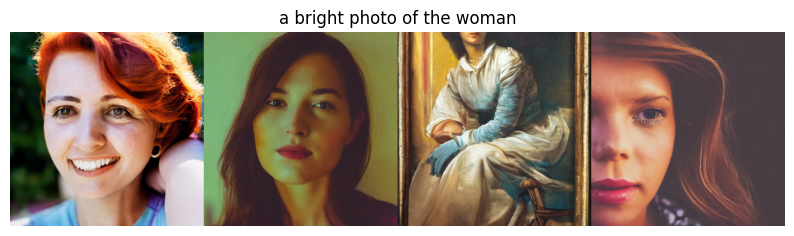

In [12]:
# prompt = random.choice(imagenet_templates_small).format("woman")
prompt = "a bright photo of the woman"
run_prompt(pipe, prompt, num_images_per_seed=4)

The above result should be  

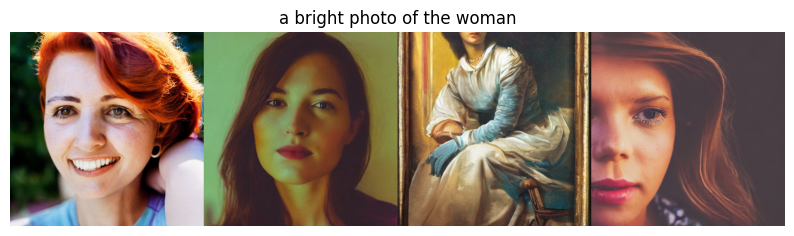

In [13]:
print("Tokenizer vocabulary size:", len(pipe.tokenizer))
new_tokens = load_learned_concepts(pipe, concept_path, device)
print("Tokenizer vocabulary size:", len(pipe.tokenizer))

Tokenizer vocabulary size: 49408
Loading learned nodes from ['v0', 'v1', 'v2']...
Added 2 tokens to the tokenizer.
Prompts loaded to pipe ...
dict_keys(['<cat_sculpture_v1>', '<cat_sculpture_v2>'])
Tokenizer vocabulary size: 49410


  0%|          | 0/25 [00:00<?, ?it/s]

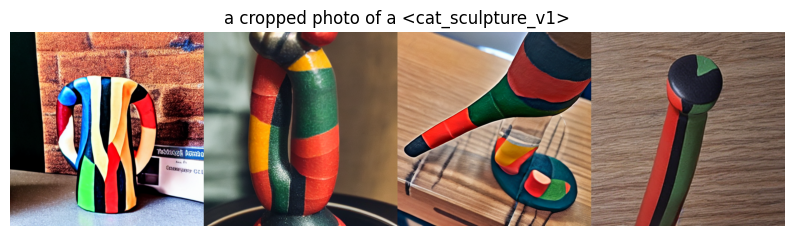

In [14]:
prompt = random.choice(imagenet_templates_small).format(new_tokens[0])
run_prompt(pipe, prompt, 4)

  0%|          | 0/25 [00:00<?, ?it/s]

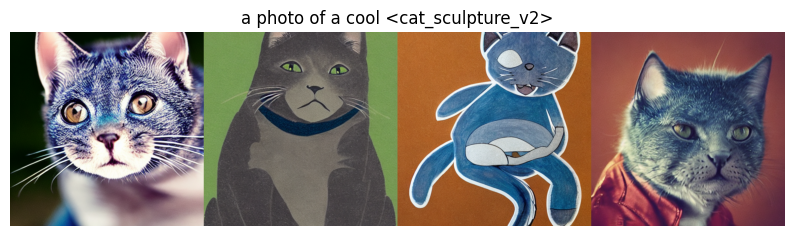

In [15]:
prompt = random.choice(imagenet_templates_small).format(new_tokens[1])
run_prompt(pipe, prompt, 4)

# Text Embedding Analysis

In [16]:
# find_closest_words('dog', 10)

In [17]:
# find_closest_words('<canada_bear_v1>', 10)

In [18]:
# print(get_word_embedding('dog').shape) # 768
# print(get_null_embedding().shape) # bs x 77 x 768, 77 = <bos> + <eos> * 76
# print(get_sentence_embedding("dog").shape) # bs x 77 x 768

In [19]:
# paper_token = torch.load(paper_token_path)
# print(paper_token.keys())
# print(paper_token['cat'].keys())
# find_closest_words_by_emb(paper_token['cat']['<cat_v1>'], 10)

# Attention Map Visulization (P2P)

In [20]:
from typing import Optional, Union, Tuple, List, Callable, Dict
import torch
from PIL import Image
from diffusers import StableDiffusionPipeline
import torch.nn.functional as nnf
import numpy as np
import abc
import utils.ptp_utils as ptp_utils
import utils.seq_aligner as seq_aligner

In [21]:
LOW_RESOURCE = False
MAX_NUM_WORDS = 77

In [22]:
class LocalBlend:

    def __call__(self, x_t, attention_store):
        k = 1
        maps = attention_store["down_cross"][2:4] + attention_store["up_cross"][:3]
        maps = [item.reshape(self.alpha_layers.shape[0], -1, 1, 16, 16, MAX_NUM_WORDS) for item in maps]
        maps = torch.cat(maps, dim=1)
        maps = (maps * self.alpha_layers).sum(-1).mean(1)
        mask = nnf.max_pool2d(maps, (k * 2 + 1, k * 2 +1), (1, 1), padding=(k, k))
        mask = nnf.interpolate(mask, size=(x_t.shape[2:]))
        mask = mask / mask.max(2, keepdims=True)[0].max(3, keepdims=True)[0]
        mask = mask.gt(self.threshold)
        mask = (mask[:1] + mask[1:]).float()
        x_t = x_t[:1] + mask * (x_t - x_t[:1])
        return x_t
       
    def __init__(self, prompts: List[str], words: [List[List[str]]], threshold=.3):
        alpha_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
        for i, (prompt, words_) in enumerate(zip(prompts, words)):
            if type(words_) is str:
                words_ = [words_]
            for word in words_:
                ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                alpha_layers[i, :, :, :, :, ind] = 1
        self.alpha_layers = alpha_layers.to(device)
        self.threshold = threshold

class AttentionControl(abc.ABC):
    
    def step_callback(self, x_t):
        return x_t
    
    def between_steps(self):
        return
    
    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0
    
    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn
    
    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class EmptyControl(AttentionControl):
    
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        return attn
    
    
class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

In [23]:
class AttentionControlEdit(AttentionStore, abc.ABC):
    
    def step_callback(self, x_t):
        if self.local_blend is not None:
            x_t = self.local_blend(x_t, self.attention_store)
        return x_t
        
    def replace_self_attention(self, attn_base, att_replace):
        if att_replace.shape[2] <= 16 ** 2:
            return attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
        else:
            return att_replace
    
    @abc.abstractmethod
    def replace_cross_attention(self, attn_base, att_replace):
        raise NotImplementedError
    
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet)
        if is_cross or (self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]):
            h = attn.shape[0] // (self.batch_size)
            attn = attn.reshape(self.batch_size, h, *attn.shape[1:])
            attn_base, attn_repalce = attn[0], attn[1:]
            if is_cross:
                alpha_words = self.cross_replace_alpha[self.cur_step]
                attn_repalce_new = self.replace_cross_attention(attn_base, attn_repalce) * alpha_words + (1 - alpha_words) * attn_repalce
                attn[1:] = attn_repalce_new
            else:
                attn[1:] = self.replace_self_attention(attn_base, attn_repalce)
            attn = attn.reshape(self.batch_size * h, *attn.shape[2:])
        return attn
    
    def __init__(self, prompts, num_steps: int,
                 cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]],
                 self_replace_steps: Union[float, Tuple[float, float]],
                 local_blend: Optional[LocalBlend]):
        super(AttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)
        self.cross_replace_alpha = ptp_utils.get_time_words_attention_alpha(prompts, num_steps, cross_replace_steps, tokenizer).to(device)
        if type(self_replace_steps) is float:
            self_replace_steps = 0, self_replace_steps
        self.num_self_replace = int(num_steps * self_replace_steps[0]), int(num_steps * self_replace_steps[1])
        self.local_blend = local_blend

class AttentionReplace(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        return torch.einsum('hpw,bwn->bhpn', attn_base, self.mapper)
      
    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper = seq_aligner.get_replacement_mapper(prompts, tokenizer).to(device)
        

class AttentionRefine(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        attn_base_replace = attn_base[:, :, self.mapper].permute(2, 0, 1, 3)
        attn_replace = attn_base_replace * self.alphas + att_replace * (1 - self.alphas)
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionRefine, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper, alphas = seq_aligner.get_refinement_mapper(prompts, tokenizer)
        self.mapper, alphas = self.mapper.to(device), alphas.to(device)
        self.alphas = alphas.reshape(alphas.shape[0], 1, 1, alphas.shape[1])


class AttentionReweight(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        if self.prev_controller is not None:
            attn_base = self.prev_controller.replace_cross_attention(attn_base, att_replace)
        attn_replace = attn_base[None, :, :, :] * self.equalizer[:, None, None, :]
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float, equalizer,
                local_blend: Optional[LocalBlend] = None, controller: Optional[AttentionControlEdit] = None):
        super(AttentionReweight, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.equalizer = equalizer.to(device)
        self.prev_controller = controller


def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float],
                  Tuple[float, ...]]):
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select,)
    equalizer = torch.ones(len(values), 77)
    values = torch.tensor(values, dtype=torch.float32)
    for word in word_select:
        inds = ptp_utils.get_word_inds(text, word, tokenizer)
        equalizer[:, inds] = values
    return equalizer

In [24]:
def aggregate_attention(prompts, attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def show_cross_attention(prompts, attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(prompts, attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = ptp_utils.text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    attn_map = np.stack(images, axis=0)
    ptp_utils.view_images(attn_map)
    return attn_map
    

# def show_self_attention_comp(prompts, attention_store: AttentionStore, res: int, from_where: List[str],
#                         max_com=10, select: int = 0):
#     attention_maps = aggregate_attention(prompts, attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2))
#     u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
#     images = []
#     for i in range(max_com):
#         image = vh[i].reshape(res, res)
#         image = image - image.min()
#         image = 255 * image / image.max()
#         image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
#         image = Image.fromarray(image).resize((256, 256))
#         image = np.array(image)
#         images.append(image)
#     ptp_utils.view_images(np.concatenate(images, axis=1))

  0%|          | 0/26 [00:00<?, ?it/s]

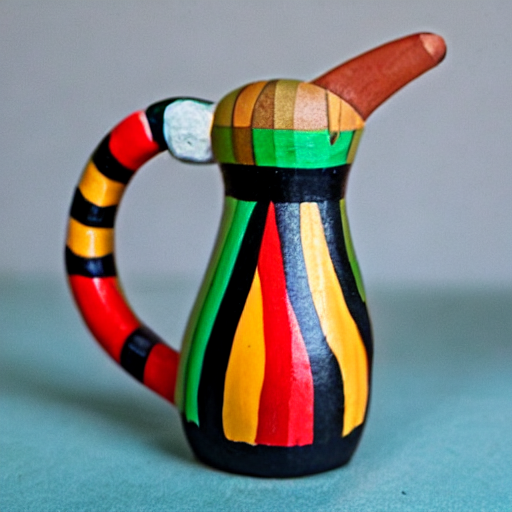

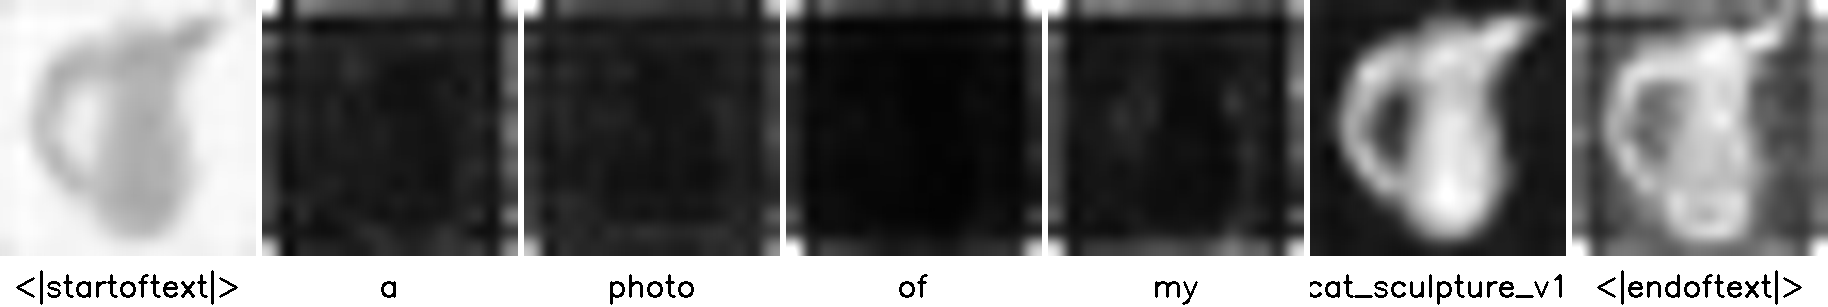

In [25]:
SEED = 42
prompts = ["a photo of my <cat_sculpture_v1>"]
g_cpu = torch.Generator().manual_seed(SEED)
torch.manual_seed(SEED)

controller = AttentionStore()
images, x_t = ptp_utils.text2image_ldm_stable(pipe, prompts, controller, latent=None, num_inference_steps=25, guidance_scale=7.5, generator=None, low_resource=LOW_RESOURCE)
ptp_utils.view_images(images)

attn_map = show_cross_attention(prompts, controller, res=16, from_where=("up", "down"))

In [26]:
def image2latent(vae, image):
    """
    Encodes an image into latent space using the VAE encoder.
    
    Args:
        vae: The variational autoencoder (VAE) model.
        image: A numpy array representing the image, with shape (B, H, W, C) and values in [0, 255].
    
    Returns:
        latent: The encoded latent representation.
    """
    image = torch.tensor(image, dtype=torch.float16) / 255.0  # Normalize to [0, 1]
    image = (image - 0.5) * 2  # Scale to [-1, 1]
    image = image.permute(0, 3, 1, 2).to(vae.device)  # Convert to (B, C, H, W)
    
    with torch.no_grad():
        latent = vae.encode(image)['latent_dist'].mean  # Get latent distribution mean
    
    latent = latent * 0.18215  # Scale factor used in diffusion models
    return latent.detach().cpu().numpy()



def latent2image(vae, latent):
    """
    Decodes a latent into image space using the VAE decoder.
    
    Args:
        vae: The variational autoencoder (VAE) model.
        latent: A numpy array representing the latent, with shape (B, H, W//8, C//8).
        
    Returns:
        image: The decoded image representation.
    """
    latent = torch.tensor(latent).to(vae.device)
    latent = 1 / 0.18215 * latent
    image = vae.decode(latent)['sample']
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).astype(np.uint8)
    return image

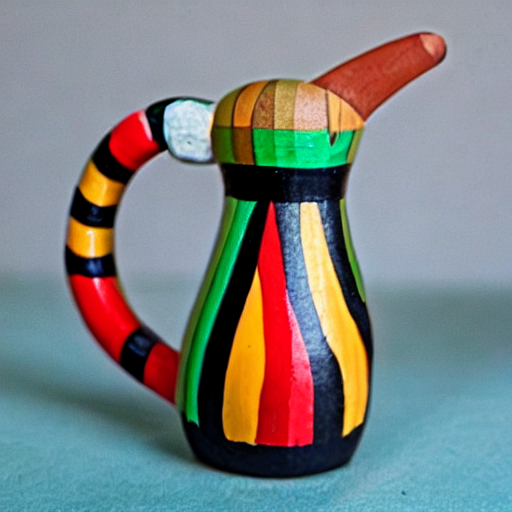

In [27]:
latents = image2latent(vae, images)
new_images = latent2image(vae, latents)
ptp_utils.view_images(new_images)

In [28]:
from torchvision import transforms
original_image = Image.open("/home/jack/Code/Research/instree_main/input_concepts/cat_sculpture/v0/1.jpeg")

# Define transformation: resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to a size divisible by 8, e.g., 256x256
    transforms.ToTensor(),  # Convert image to a tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize
])

# Apply the transformation to the image
image_tensor = transform(original_image)

# If the image is RGB, it will have shape (3, H, W)
# You need to add a batch dimension to it, making it (1, 3, H, W)
image_tensor = image_tensor.unsqueeze(0)
print(image_tensor.shape)

torch.Size([1, 3, 512, 512])


In [29]:
# use numpy to load image
original_image = original_image.resize((512, 512))
# expand an extra dimension at the beginning
original_image = np.expand_dims(original_image, axis=0)
original_image.shape

(1, 512, 512, 3)

(1, 4, 64, 64)
(1, 512, 512, 3)


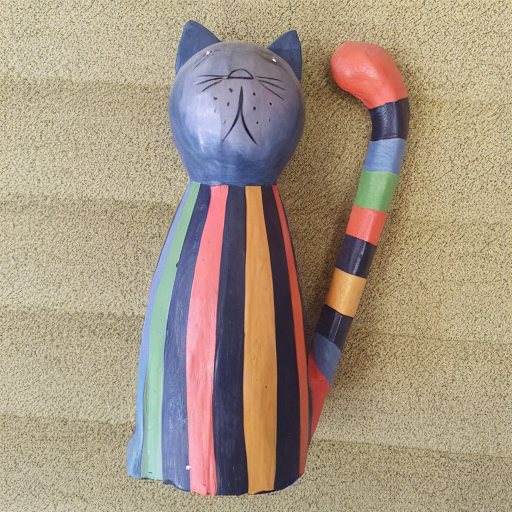

In [30]:
original_image_latent = image2latent(vae, original_image)
print(original_image_latent.shape)
original_image_reconstructed = latent2image(vae, original_image_latent)
print(original_image_reconstructed.shape)
ptp_utils.view_images(original_image_reconstructed)

  0%|          | 0/1 [00:00<?, ?it/s]

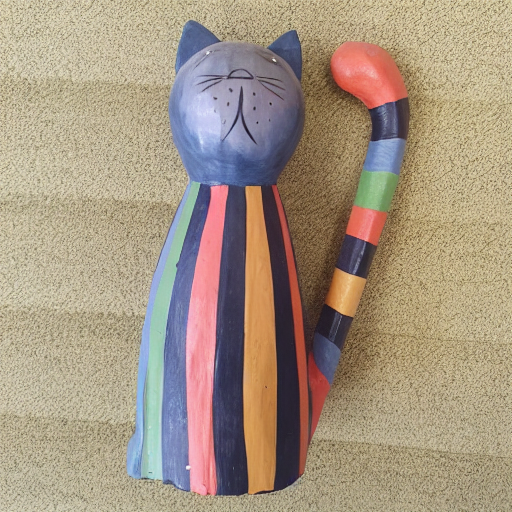

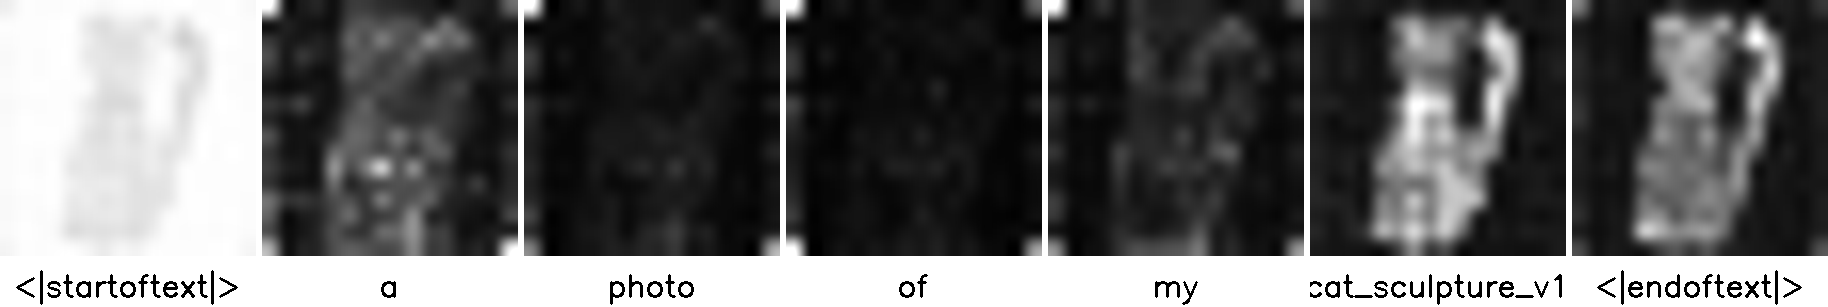

In [31]:
SEED = 42
prompts = ["a photo of my <cat_sculpture_v1>"]
g_cpu = torch.Generator().manual_seed(SEED)
torch.manual_seed(SEED)

original_image_latent_t = torch.tensor(original_image_latent, dtype=torch.float16).to(device)

controller = AttentionStore()
images, x_t = ptp_utils.text2image_ldm_stable(pipe, prompts, controller, latent=original_image_latent_t, num_inference_steps=1, guidance_scale=7.5, generator=None, low_resource=LOW_RESOURCE)
ptp_utils.view_images(images)

attn_map = show_cross_attention(prompts, controller, res=16, from_where=("up", "down"))

## Attention Maps Timestep Analysis

In [32]:
def load_all_learned_concepts(pipe, emb_dir, device):
    """
    Loads the learned tokens from the concept directory into the pipe.
    emb_dir: /home/jack/Code/Research/instree_main/outputs/cat_sculpture/v0/v0_seed111/embeds
    """
    all_steps_nodes = sorted(os.listdir(emb_dir))
    all_nodes = {}
    print(f"Loading learned nodes from {len(all_steps_nodes)} different steps...")
    concept = emb_dir.split("/")[-4]
    for node in all_steps_nodes:
        both_node_code = torch.load(f"{emb_dir}/{node}")
        step = node.split("-")[-1][:-4]
        for k, v in both_node_code.items():
            all_nodes[f"<{concept}_{k}_{step}>"] = v

    load_tokens(pipe, all_nodes, device)
    print("Prompts loaded to pipe ...")
    print(all_nodes.keys())
    return list(all_nodes.keys())

In [33]:
emb_path = "/home/jack/Code/Research/instree_main/outputs/cat_sculpture/v0/v0_seed111/embeds"
print("Tokenizer vocabulary size:", len(pipe.tokenizer))
load_all_learned_concepts(pipe, emb_path, device)
print("Tokenizer vocabulary size:", len(pipe.tokenizer))

Tokenizer vocabulary size: 49410
Loading learned nodes from 20 different steps...
Added 40 tokens to the tokenizer.
Prompts loaded to pipe ...
dict_keys(['<cat_sculpture_<*>_100>', '<cat_sculpture_<&>_100>', '<cat_sculpture_<*>_1000>', '<cat_sculpture_<&>_1000>', '<cat_sculpture_<*>_150>', '<cat_sculpture_<&>_150>', '<cat_sculpture_<*>_200>', '<cat_sculpture_<&>_200>', '<cat_sculpture_<*>_250>', '<cat_sculpture_<&>_250>', '<cat_sculpture_<*>_300>', '<cat_sculpture_<&>_300>', '<cat_sculpture_<*>_350>', '<cat_sculpture_<&>_350>', '<cat_sculpture_<*>_400>', '<cat_sculpture_<&>_400>', '<cat_sculpture_<*>_450>', '<cat_sculpture_<&>_450>', '<cat_sculpture_<*>_50>', '<cat_sculpture_<&>_50>', '<cat_sculpture_<*>_500>', '<cat_sculpture_<&>_500>', '<cat_sculpture_<*>_550>', '<cat_sculpture_<&>_550>', '<cat_sculpture_<*>_600>', '<cat_sculpture_<&>_600>', '<cat_sculpture_<*>_650>', '<cat_sculpture_<&>_650>', '<cat_sculpture_<*>_700>', '<cat_sculpture_<&>_700>', '<cat_sculpture_<*>_750>', '<cat_scu

In [34]:
# SEED = 42

# for s in range(0, 1001, 50):
#     SEED = 42
#     tok = "<&>"
#     prompts = [f"a photo of my <cat_sculpture_{tok}_{s}>"]
#     if s == 0:
#         prompts = ["a photo of my object"]
#     g_cpu = torch.Generator().manual_seed(SEED)
#     torch.manual_seed(SEED)

#     # controller = AttentionStore()
#     # images, x_t = ptp_utils.text2image_ldm_stable(pipe, prompts, controller, latent=None, num_inference_steps=25, guidance_scale=7.5, generator=None, low_resource=LOW_RESOURCE)
#     # ptp_utils.view_images(images)
#     # show_cross_attention(prompts, controller, res=16, from_where=("up", "down"))


#     # prompts = [f"a photo of my <cat_sculpture_<*>_{s}>"]
#     # g_cpu = torch.Generator().manual_seed(SEED)
#     # torch.manual_seed(SEED)

#     original_image_latent_t = torch.tensor(original_image_latent, dtype=torch.float16).to(device)

#     controller = AttentionStore()
#     images, x_t = ptp_utils.text2image_ldm_stable(pipe, prompts, controller, latent=original_image_latent_t, num_inference_steps=1, guidance_scale=7.5, generator=None, low_resource=LOW_RESOURCE)
#     # ptp_utils.view_images(images)

#     print(f"Step {s}")
#     attn_map = show_cross_attention(prompts, controller, res=16, from_where=("up", "down"))
#     print("==========")
#     # save attn_map to folder
#     print(attn_map.shape)
#     attn_map = np.concatenate(attn_map, axis=1)
#     os.makedirs(f"attn_{tok}", exist_ok=True)
#     Image.fromarray(attn_map).save(f"attn_{tok}/{tok}_{s}.png")

In [35]:
import cv2

def otsu_thresholding(image: np.ndarray) -> np.ndarray:
    """
    Apply Otsu's thresholding to a color image by converting it to grayscale.
    
    Parameters:
        image (np.ndarray): Input color image of shape (250, 256, 3).
    
    Returns:
        np.ndarray: Binary thresholded image.
    """
    # Convert to grayscale
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Otsu's thresholding
    _, binary_image = cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return np.expand_dims(binary_image, axis=2)

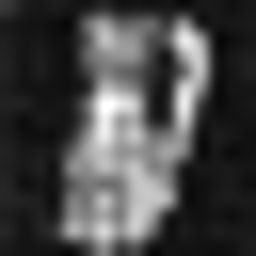

In [36]:
ptp_utils.view_images(attn_map[-2][:256])

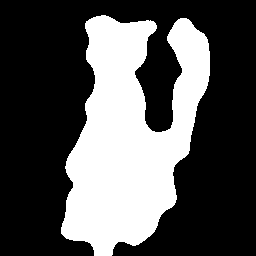

In [38]:
ptp_utils.view_images(otsu_thresholding(attn_map[-2][:256]))